<a href="https://colab.research.google.com/github/YuruHuang/deep-learning-menu-healthiness/blob/main/02_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will fine tune existing state-of-art models to our menu healthiness prediction problem. 

From Tom Bishop's experiments with the takeaway cuisine classifier, the step that made the most difference was when he **fine tuned some of the layers**. Below are the basic steps for transfer learning: 

>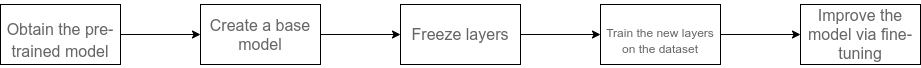

# Data Preprocessing 

## Load the data!

In [7]:
# all the packages load
#!pip install unidecode
#!pip install tensorflow-text
import tensorflow_text
from unidecode import unidecode
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
import string
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [8]:
from sklearn.model_selection import train_test_split
justeat_menu = pd.read_csv('JustEat_extracted_211021.csv')
justeat_menu.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,n_reviews,average_review,item_price_mean,item_price_median,n_items,url,cuisine,address,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,review
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,View 551 reviews,5.06 stars out of 6.,6.037634,7.000,93,URL,"Kebab,Pizza,Halal","25 Windmill Brae, Aberdeen, AB11 6HU",AB11 6HU,AB11,5,11,2,5.504342,1,551.0
1,71703,7,10,2,14,0,0,4,Paco's Tacos,View 2314 reviews,4.65 stars out of 6.,5.431358,4.450,162,URL,"Mexican,American","42-44 Market Street, Aberdeenshire, AB11 5PL",AB11 5PL,AB11,4,14,2,5.010865,0,2314.0
2,6885,0,16,12,1,0,0,2,Dil Se,View 1392 reviews,5.19 stars out of 6.,7.473418,8.225,158,URL,"Indian,Curry","Unit 8, The Green Berrymuir Road, Portlethen, ...",AB12 4UN,AB12,2,1,12,9.355489,4,1392.0
3,122605,5,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,View 386 reviews,5.16 stars out of 6.,8.069737,7.700,152,URL,"Pizza,Kebab","483a Great Western Road, Aberdeen, AB10 6NN",AB10 6NN,AB10,1,15,6,5.642945,1,386.0
4,44832,0,16,2,1,0,0,2,Lasan Healthy Indian Brasserie,View 595 reviews,5.04 stars out of 6.,6.877143,4.500,105,URL,"Indian,Healthy","Unit 2 Westhill Drive, Westhill, Aberdeenshire...",AB32 6FS,AB32,2,1,2,8.357649,3,595.0


Using Tom Bishop's methods to clean restaurant names (replace some special characters)

In [9]:
justeat_menu['ascii_name'] = justeat_menu.rest_name.apply(lambda x: unidecode(str(x)))
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name.str.replace('`',"'")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('~'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(']'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('['," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('\\'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('%'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('*'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(':'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('+'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('&'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('/'," ")

In [ ]:
X_train, X_test_, y_train, y_test_ = train_test_split(justeat_menu['ascii_name_fix'].str.lower(), justeat_menu['predict'], test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_,y_test_, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((49117,), (49117,), (2729,), (2729,), (2729,), (2729,))

## Create tensorflow datasets for faster processing

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.float64)>

# Tokenization and Embedding

## Tokenization (character level)


In [ ]:
# create a character level tokenizer 

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars("McDonald's - Cambridge")

"M c D o n a l d ' s   -   C a m b r i d g e"

In [ ]:
# splits into character-level 
train_chars = [split_chars(name) for name in X_train]
test_chars = [split_chars(name) for name in X_test]
val_chars = [split_chars(name) for name in X_val]

print(train_chars[0])

c h i c a g o   k e b a b     a n d     b u r g e r s


In [ ]:
# What's the average character length?
char_lens = [len(name) for name in X_train]
mean_char_len = np.mean(char_lens)
mean_char_len

18.262658549992874

In [ ]:
np.percentile(char_lens, [95,99,100])
output_seq_char_len = max(char_lens)
print(output_seq_char_len) # see all the characters (restaurant names are quite short )

57


In [ ]:
len(list(string.ascii_lowercase + " -'@&)(." +"0123456789"))+1 # one for unknown characters

45

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = 45
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 38
5 most common characters: ['', '[UNK]', 'a', 'e', 'i']
5 least common characters: ['5', '8', '6', '7', '9']


In [ ]:
# Test out character vectorizer
random_train_chars = np.random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p a r m e s a n   h o u s e

Length of chars: 13

Vectorized chars:
[[14  2  5 19  3  6  2  7 11  8 16  6  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0]]

Length of vectorized chars: 57


## Embedding layer

In [28]:
# Pre trained embedding layer
ulmfit = hub.load('https://tfhub.dev/edrone/ulmfit/en/sp35k_uncased/1')
encoder = hub.KerasLayer(ulmfit.signatures['string_encoder'], trainable= False, name = "universal_language_model")

In [ ]:
# Character embedding layer 
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed",
                              )


# Model 0: pre-trained embedding layer from Universal Language Model

In [ ]:
# frozen weights - embedding layer uses the default subword tokenization
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = encoder(token_inputs) # the output is a dictionary consisting of output_flat and output_rows
token_embeddings_ragged = tf.RaggedTensor.from_row_splits(token_embeddings['output_flat'],   # converting to RaggedTensor
                                                 token_embeddings['output_rows'])
vector_average = tf.reduce_mean(token_embeddings_ragged, axis=1) 
token_output = layers.Dense(128, activation="relu")(vector_average)
model_0 = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output, name ='ULM_embedding')

In [ ]:
model_0.summary()

Model: "ULM_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 universal_language_model (Kera  {'output_flat': (No  34262464   ['token_input[0][0]']            
 sLayer)                        ne, 400),                                                         
                                 'output_rows': (No                                               
                                ne,)}                                                             
                                                                                                  
 tf.RaggedTensor.from_row_split  (None, None, 400)   0           ['universal_language_

In [ ]:
model_0.compile(loss=tf.keras.losses.mean_absolute_error,
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Fit the model on tokens and chars
model_0_history = model_0.fit(train_dataset, # train on dataset of token and characters
                              epochs=25,
                              validation_data=valid_dataset)

Epoch 1/25
1535/1535 [==============================] - 136s 89ms/step - loss: 0.9946 - val_loss: 1.0363
Epoch 2/25
1535/1535 [==============================] - 128s 84ms/step - loss: 0.9921 - val_loss: 1.0347
Epoch 3/25
1535/1535 [==============================] - 128s 83ms/step - loss: 0.9898 - val_loss: 1.0334
Epoch 4/25
1535/1535 [==============================] - 129s 84ms/step - loss: 0.9877 - val_loss: 1.0322
Epoch 5/25
1535/1535 [==============================] - 128s 83ms/step - loss: 0.9858 - val_loss: 1.0312
Epoch 6/25
1535/1535 [==============================] - 128s 83ms/step - loss: 0.9841 - val_loss: 1.0302
Epoch 7/25
1535/1535 [==============================] - 128s 83ms/step - loss: 0.9825 - val_loss: 1.0292
Epoch 8/25
1535/1535 [==============================] - 128s 83ms/step - loss: 0.9810 - val_loss: 1.0282
Epoch 9/25
1535/1535 [==============================] - 210s 137ms/step - loss: 0.9796 - val_loss: 1.0273
Epoch 10/25
1535/1535 [==============================]

In [ ]:
for layer_number, layer in enumerate(model_0.layers):
  print(layer_number, layer.name, layer.trainable)

0 token_input True
1 universal_language_model False
2 tf.RaggedTensor.from_row_splits_4 True
3 tf.math.reduce_mean_4 True
4 dense_18 True


In [ ]:
model_0.trainable = True

# Recompile the model (always recompile after any adjustments to a model)
model_0.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001)) # lr is 10x lower than before for fine-tuning)

In [ ]:
# fine tune for another 25 epochs 
fine_tune_epochs = 50

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune_model_0= model_0.fit(train_dataset,
                                       epochs=fine_tune_epochs,
                                       validation_data=valid_dataset,
                                               initial_epoch=model_0_history.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(valid_dataset)))


Epoch 25/50
1535/1535 [==============================] - 403s 259ms/step - loss: 0.8708 - val_loss: 0.8694
Epoch 26/50
1535/1535 [==============================] - 381s 248ms/step - loss: 0.7632 - val_loss: 0.8483
Epoch 27/50
1535/1535 [==============================] - 379s 247ms/step - loss: 0.7065 - val_loss: 0.8222
Epoch 28/50
1535/1535 [==============================] - 379s 247ms/step - loss: 0.6593 - val_loss: 0.8165
Epoch 29/50
1535/1535 [==============================] - 379s 247ms/step - loss: 0.6144 - val_loss: 0.8406
Epoch 30/50
1535/1535 [==============================] - 379s 247ms/step - loss: 0.5718 - val_loss: 0.8771
Epoch 31/50
1535/1535 [==============================] - 378s 246ms/step - loss: 0.5357 - val_loss: 0.8290
Epoch 32/50
1535/1535 [==============================] - 379s 247ms/step - loss: 0.5035 - val_loss: 0.8128
Epoch 33/50
1535/1535 [==============================] - 378s 247ms/step - loss: 0.4706 - val_loss: 0.8416
Epoch 34/50
1535/1535 [==============

# Model 1: Combining character level tokenization layer and pre-trained embedding layer


In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = encoder(token_inputs) # the output is a dictionary consisting of output_flat and output_rows
token_embeddings_ragged = tf.RaggedTensor.from_row_splits(token_embeddings['output_flat'],   # converting to RaggedTensor
                                                 token_embeddings['output_rows'])
vector_average = tf.reduce_mean(token_embeddings_ragged, axis=1) 
token_output = layers.Dense(128, activation="relu")(vector_average)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1)(final_dropout)

# 5. Construct model with char and token inputs
model_1 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_1_token_and_char_embeddings")

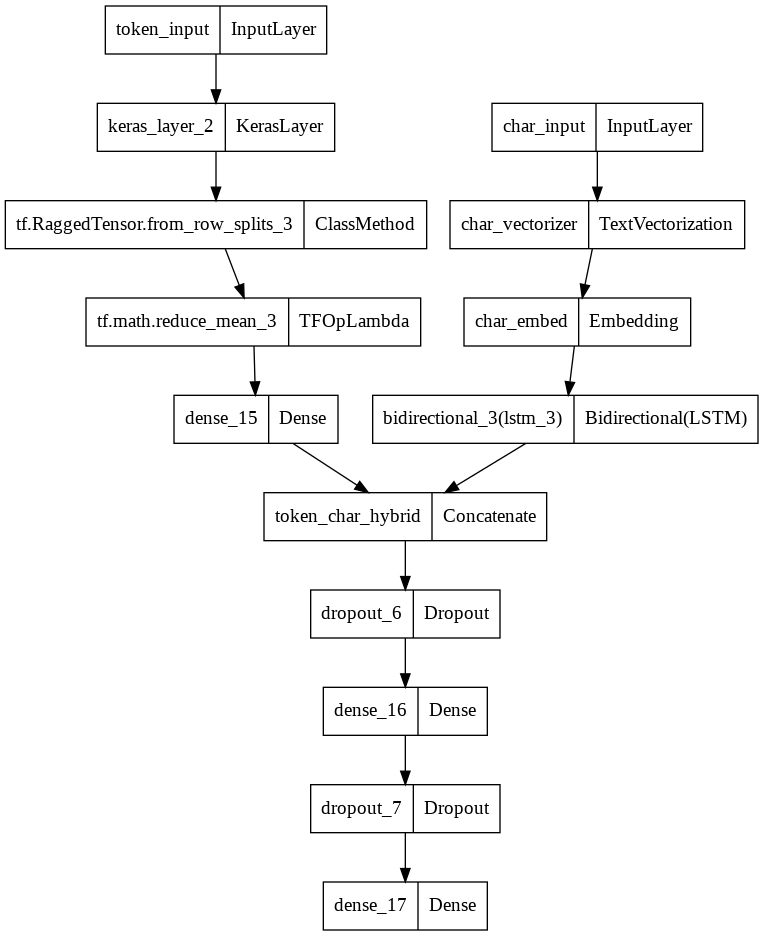

In [ ]:
plot_model(model_1)

In [ ]:
model_1.summary()

Model: "model_1_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'output_flat': (No  34262464    ['token_input[0][0]']            
                                ne, 400),                                                         
                                 'output_rows': (No                                               
                                ne,)}                                                             
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           [

In [ ]:
# Compile token char model
model_1.compile(loss=tf.keras.losses.mean_absolute_error,
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["mae",'mse'])

## create tf datasets

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((X_train, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((X_val, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None,)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None,)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the model on tokens and chars
model_1_history = model_1.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
153/153 [==============================] - 58s 302ms/step - loss: 1.5410 - mae: 1.5410 - mse: 4.1390 - val_loss: 1.0907 - val_mae: 1.0907 - val_mse: 1.9204
Epoch 2/10
153/153 [==============================] - 43s 279ms/step - loss: 1.2283 - mae: 1.2283 - mse: 2.5204 - val_loss: 0.8422 - val_mae: 0.8422 - val_mse: 1.4549
Epoch 3/10
153/153 [==============================] - 43s 279ms/step - loss: 1.2080 - mae: 1.2080 - mse: 2.3673 - val_loss: 0.8121 - val_mae: 0.8121 - val_mse: 1.4034
Epoch 4/10
153/153 [==============================] - 43s 278ms/step - loss: 1.1414 - mae: 1.1414 - mse: 2.1162 - val_loss: 0.8969 - val_mae: 0.8969 - val_mse: 1.5143
Epoch 5/10
153/153 [==============================] - 43s 281ms/step - loss: 1.1176 - mae: 1.1176 - mse: 2.1223 - val_loss: 0.9235 - val_mae: 0.9235 - val_mse: 1.7056
Epoch 6/10
153/153 [==============================] - 42s 277ms/step - loss: 1.1050 - mae: 1.1050 - mse: 2.0474 - val_loss: 0.8122 - val_mae: 0.8122 - val_mse: 1.357

# Model 2: Incorporating hygiene rating into the model

## Data preparation
Add hygiene ratings

In [10]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,Unnamed: 0,0
0,0,Pass
1,1,NaN
2,2,Pass
3,3,NaN
4,4,Improvement Required


In [11]:
# How many of the restaurants have food hyginene rating? 
import collections
collections.Counter(ratings.iloc[:,1])

Counter({'0': 59,
         '1': 985,
         '2': 1209,
         '3': 6788,
         '4': 10075,
         '5': 23643,
         'Improvement Required': 306,
         'Pass': 2820,
         'Pass and Eat Safe': 9,
         nan: 8681})

In [13]:
justeat_menu['hygiene'] = ratings.iloc[:,1]

In [16]:
# focus on England only: restaurants with hyginene ratings
justeat_hr = justeat_menu[justeat_menu['hygiene'].notnull()]
justeat_eng = justeat_hr[justeat_hr['hygiene'].str.contains('0|1|2|3|4|5')]
justeat_eng['hg_rating'] = justeat_eng.hygiene.astype("float64")
justeat_eng['ascii_name_fix'] = justeat_eng.rest_name.astype("string").str.lower()
justeat_eng.hg_rating.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


dtype('float64')

In [19]:
X_train_hr, X_test_, y_train_hr, y_test_ = train_test_split(justeat_eng[['ascii_name_fix','hg_rating']], justeat_eng['predict'], test_size=0.1, random_state=42)
X_val_hr, X_test_hr, y_val_hr, y_test_hr = train_test_split(X_test_,y_test_, test_size=0.5, random_state=42)
X_train_hr.shape, y_train_hr.shape, X_test_hr.shape, y_test_hr.shape, X_val_hr.shape, y_val_hr.shape

((38483, 2), (38483,), (2138, 2), (2138,), (2138, 2), (2138,))

In [26]:
# normalize the hygiene scores 
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
X_train_hr['hg_rating']=std_scaler.fit_transform(X_train_hr[['hg_rating']])
X_val_hr['hg_rating']=std_scaler.transform(X_val_hr[['hg_rating']])
X_test_hr['hg_rating']=std_scaler.transform(X_test_hr[['hg_rating']])

## Create tf datasets

In [43]:
train_hygiene_token_data = tf.data.Dataset.from_tensor_slices((X_train_hr.ascii_name_fix, X_train_hr.hg_rating)) # make data
train_hygiene_token_labels = tf.data.Dataset.from_tensor_slices(y_train_hr) # make labels
train_hygiene_token_dataset = tf.data.Dataset.zip((train_hygiene_token_data, train_hygiene_token_labels)) # combine data and labels

# Repeat same steps validation data
val_hygiene_token_data = tf.data.Dataset.from_tensor_slices((X_val_hr.ascii_name_fix, X_val_hr.hg_rating))
val_hygiene_token_labels = tf.data.Dataset.from_tensor_slices(y_val_hr)
val_hygiene_token_dataset = tf.data.Dataset.zip((val_hygiene_token_data, val_hygiene_token_labels))

# Prefetch and batch train data
train_hygiene_token_dataset = train_hygiene_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
val_hygiene_token_dataset = val_hygiene_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Combining pre-trained embedding layer (ULM) and hygiene rating

In [35]:
encoder = hub.KerasLayer(ulmfit.signatures['string_encoder'], trainable= False, name = "universal_language_model")

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = encoder(token_inputs) # the output is a dictionary consisting of output_flat and output_rows
token_embeddings_ragged = tf.RaggedTensor.from_row_splits(token_embeddings['output_flat'],   # converting to RaggedTensor
                                                 token_embeddings['output_rows'])
vector_average = tf.reduce_mean(token_embeddings_ragged, axis=1) 
token_output = layers.Dense(128, activation="relu")(vector_average)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup hygiene rating model 
hygiene_inputs = layers.Input(shape=(1,), name="hygiene_input")
hygiene_output = layers.Dense(128, activation="relu")(hygiene_inputs)
hygiene_model = tf.keras.Model(inputs=hygiene_inputs,
                            outputs=hygiene_output)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_hygiene_concat = layers.Concatenate(name="token_hygiene_hybrid")([token_model.output, 
                                                                  hygiene_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_hygiene_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1)(final_dropout)

# 5. Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=[token_model.input, hygiene_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_hygiene_pretrained")

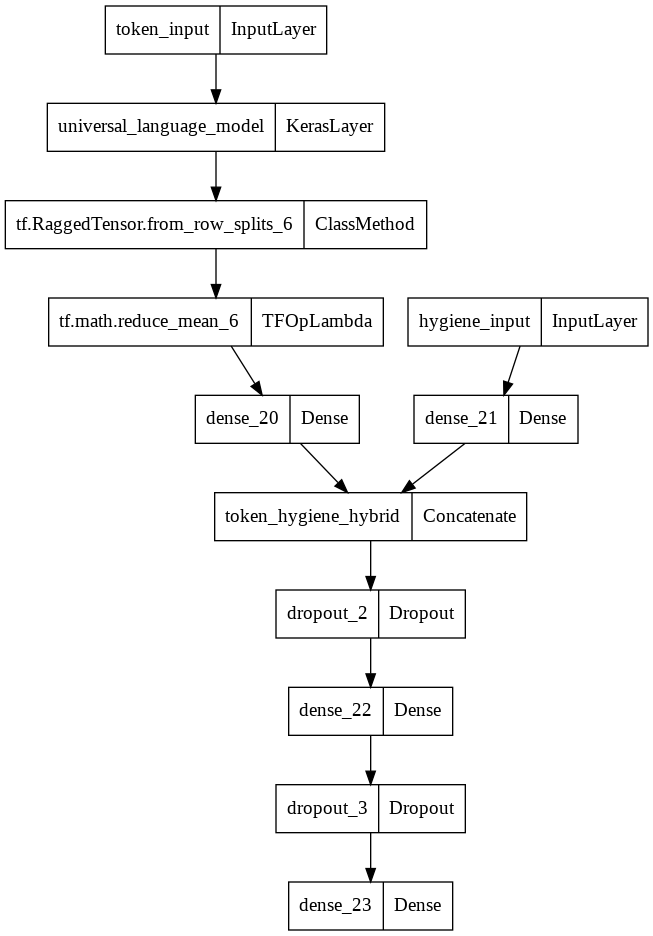

In [36]:
plot_model(model_2)

In [37]:
model_2.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

In [47]:
# Fit the model on tokens and hygiene ratings 
model_2_history = model_2.fit(train_hygiene_token_dataset, # train on dataset of token and characters
                              #steps_per_epoch=int(0.1 * len(train_hygiene_token_dataset)),
                              epochs=20,
                              validation_data=val_hygiene_token_dataset,
                              #validation_steps=int(0.1 * len(val_hygiene_token_dataset))
                              )

Epoch 1/20
1203/1203 [==============================] - 103s 86ms/step - loss: 1.2061 - val_loss: 1.9969
Epoch 2/20
1203/1203 [==============================] - 103s 85ms/step - loss: 1.1657 - val_loss: 1.9306
Epoch 3/20
1203/1203 [==============================] - 106s 88ms/step - loss: 1.1308 - val_loss: 1.8545
Epoch 4/20
1203/1203 [==============================] - 106s 88ms/step - loss: 1.1051 - val_loss: 1.5084
Epoch 5/20
1203/1203 [==============================] - 105s 87ms/step - loss: 1.0759 - val_loss: 1.2596
Epoch 6/20
1203/1203 [==============================] - 106s 88ms/step - loss: 1.0589 - val_loss: 1.2698
Epoch 7/20
1203/1203 [==============================] - 107s 89ms/step - loss: 1.0480 - val_loss: 1.1678
Epoch 8/20
1203/1203 [==============================] - 105s 88ms/step - loss: 1.0314 - val_loss: 1.1027
Epoch 9/20
1203/1203 [==============================] - 106s 88ms/step - loss: 1.0227 - val_loss: 1.2403
Epoch 10/20
1203/1203 [==============================] 

In [51]:
# now make the unfreeze the layer 
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

model_2.trainable = True

0 token_input True
1 universal_language_model True
2 tf.RaggedTensor.from_row_splits_6 True
3 tf.math.reduce_mean_6 True
4 hygiene_input True
5 dense_20 True
6 dense_21 True
7 token_hygiene_hybrid True
8 dropout_2 True
9 dense_22 True
10 dropout_3 True
11 dense_23 True


In [57]:
# now unfreeze the layer and fine tune with lower learning rates 
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam(1e-4)) # lr is 10x lower than before for fine-tuning)

In [58]:
# fine tune for another 20 epochs 
fine_tune_epochs = 30

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune_model_2= model_2.fit(train_hygiene_token_dataset,
                                       epochs=fine_tune_epochs,
                                       validation_data=val_hygiene_token_dataset,
                                               initial_epoch=model_2_history.epoch[-1]) # start from previous last epoch


Epoch 20/30
1203/1203 [==============================] - 299s 246ms/step - loss: 0.5457 - val_loss: 0.8561
Epoch 21/30
1203/1203 [==============================] - 292s 243ms/step - loss: 0.5196 - val_loss: 0.8476
Epoch 22/30
1203/1203 [==============================] - 292s 243ms/step - loss: 0.5013 - val_loss: 0.8442
Epoch 23/30
1203/1203 [==============================] - 295s 245ms/step - loss: 0.4830 - val_loss: 0.8482
Epoch 24/30
1203/1203 [==============================] - 295s 245ms/step - loss: 0.4721 - val_loss: 0.8496
Epoch 25/30
1203/1203 [==============================] - 295s 245ms/step - loss: 0.4591 - val_loss: 0.8559
Epoch 26/30
1203/1203 [==============================] - 297s 247ms/step - loss: 0.4454 - val_loss: 0.8513
Epoch 27/30
1203/1203 [==============================] - 297s 247ms/step - loss: 0.4349 - val_loss: 0.8532
Epoch 28/30
1203/1203 [==============================] - 297s 247ms/step - loss: 0.4252 - val_loss: 0.8534
Epoch 29/30
1203/1203 [==============

# Model 3: Incorporating hygiene rating and geographical coordinates into the model 

Geographic corrdinate encoding reference: https://medium.com/riga-data-science-club/geographic-coordinate-encoding-with-tensorflow-feature-columns-e750ae338b7c
